In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install torchinfo -q


Note: you may need to restart the kernel to use updated packages.


# Pixel Coordinate Prediction using CNN

Goal:
Predict the (x,y) coordinate of the single bright pixel in a 50×50 grayscale image.

Approach:
- Generate synthetic dataset (2500 annotated images)
- Train CNN regression model
- Use MSE loss on normalized coordinates
- Visualize predictions vs ground truth


In [2]:
import random
import math
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split


In [3]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


set_seed()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [4]:
import os

BASE_DIR = "/kaggle/working/pixel_data"
IMG_DIR = os.path.join(BASE_DIR, "images")

os.makedirs(IMG_DIR, exist_ok=True)

print("Directory ready:", IMG_DIR)


Directory ready: /kaggle/working/pixel_data/images


In [5]:
IMG_SIZE = 50


def generate_and_save_dataset(n_samples: int = 2500) -> pd.DataFrame:
    """Generate dataset and save images + coordinates."""

    records = []

    for i in range(n_samples):
        img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

        x = np.random.randint(0, IMG_SIZE)
        y = np.random.randint(0, IMG_SIZE)

        img[x, y] = 255

        filename = f"img_{i:04d}.png"
        path = os.path.join(IMG_DIR, filename)

        Image.fromarray(img).save(path)

        records.append({
            "filename": filename,
            "x": x,
            "y": y
        })

    return pd.DataFrame(records)


In [6]:
labels_df = generate_and_save_dataset(2500)

labels_path = os.path.join(BASE_DIR, "labels.csv")
labels_df.to_csv(labels_path, index=False)

print("Saved CSV:", labels_path)
labels_df.head()


Saved CSV: /kaggle/working/pixel_data/labels.csv


,filename,x,y
0,img_0000.png,38,28
1,img_0001.png,14,42
2,img_0002.png,7,20
3,img_0003.png,38,18
4,img_0004.png,22,10


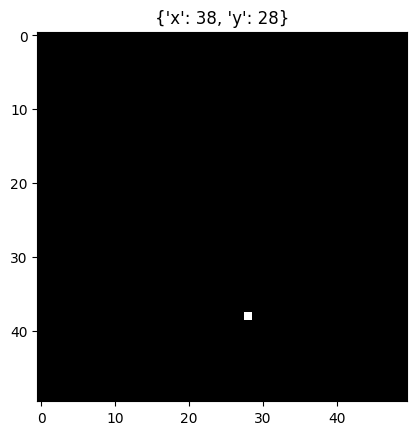

In [7]:
sample_path = os.path.join(IMG_DIR, labels_df.iloc[0]["filename"])
img = Image.open(sample_path)
plt.imshow(img, cmap="gray")
plt.title(labels_df.iloc[0][["x", "y"]].to_dict())
plt.show()


In [12]:
CSV_PATH="/kaggle/working/pixel_data/labels.csv"
labels_df = pd.read_csv(CSV_PATH)
labels_df.head()


,filename,x,y
0,img_0000.png,38,28
1,img_0001.png,14,42
2,img_0002.png,7,20
3,img_0003.png,38,18
4,img_0004.png,22,10


In [13]:
class PixelImageDataset(Dataset):
    """
    Dataset that reads saved PNG images and coordinate labels from CSV.
    """

    def __init__(self, df: pd.DataFrame, img_dir: str):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        img_path = f"{self.img_dir}/{row['filename']}"
        img = Image.open(img_path).convert("L")

        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.tensor(img).unsqueeze(0)

        # normalize coordinates
        x = row["x"] / 49.0
        y = row["y"] / 49.0

        label = torch.tensor([x, y], dtype=torch.float32)

        return img, label


In [14]:
dataset = PixelImageDataset(labels_df, IMG_DIR)

img, label = dataset[0]

print("Image shape:", img.shape)
print("Label:", label)


Image shape: torch.Size([1, 50, 50])
Label: tensor([0.7755, 0.5714])


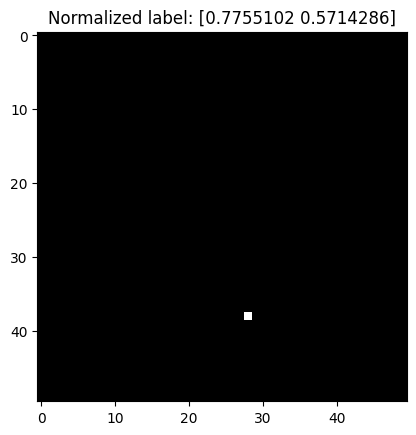

In [15]:

plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Normalized label: {label.numpy()}")
plt.show()


In [16]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("Train:", len(train_ds))
print("Val:", len(val_ds))


Train: 2000
Val: 500


In [17]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=64,
    shuffle=False
)


In [18]:
imgs, labels = next(iter(train_loader))

print("Batch images:", imgs.shape)
print("Batch labels:", labels.shape)


Batch images: torch.Size([64, 1, 50, 50])
Batch labels: torch.Size([64, 2])


## CNN Model Architecture

A compact CNN is used for coordinate regression:

- 3 convolution + pooling blocks for spatial feature extraction
- fully connected regression head
- sigmoid output layer → normalized coordinates

Model is intentionally lightweight since the localization task is simple.


In [19]:
class Model(nn.Module):
    """
    Lightweight CNN to regress the (x, y) coordinate of the single bright pixel.
    Output is normalized to [0,1] using sigmoid.
    """

    def __init__(self, in_channels: int = 1, out_channels: int = 2):
        super().__init__()

        self.relu = nn.ReLU()

        # ----- Convolution blocks -----
        # Block 1 → 50x50 → 25x25
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        # Block 2 → 25x25 → 12x12
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # Block 3 → 12x12 → 6x6
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)

        # ----- Regression head -----
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.drop1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.1)

        # Final output → (x, y)
        self.fc3 = nn.Linear(64, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # feature extraction
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))

        # flatten
        x = x.view(x.size(0), -1)

        # regression layers
        x = self.drop1(self.relu(self.fc1(x)))
        x = self.drop2(self.relu(self.fc2(x)))

        # sigmoid keeps outputs in [0,1] coordinate range
        x = torch.sigmoid(self.fc3(x))

        return x


In [23]:
import torch
from torchinfo import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(DEVICE)

summary(
    model, 
    input_size=(4, 1, 50, 50),  # batch size of 4, 1 channel, 50x50 image
    col_names=["input_size", "output_size", "num_params", "trainable"],  # show these columns
    verbose=2  # gives a more detailed layer-by-layer breakdown
)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Model                                    [4, 1, 50, 50]            [4, 2]                    --                        True
├─Conv2d: 1-1                            [4, 1, 50, 50]            [4, 16, 50, 50]           160                       True
│    └─weight                                                                                ├─144
│    └─bias                                                                                  └─16
├─ReLU: 1-2                              [4, 16, 50, 50]           [4, 16, 50, 50]           --                        --
├─MaxPool2d: 1-3                         [4, 16, 50, 50]           [4, 16, 25, 25]           --                        --
├─Conv2d: 1-4                            [4, 16, 25, 25]           [4, 32, 25, 25]           4,640                     True
│    └─weight                                             

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Model                                    [4, 1, 50, 50]            [4, 2]                    --                        True
├─Conv2d: 1-1                            [4, 1, 50, 50]            [4, 16, 50, 50]           160                       True
│    └─weight                                                                                ├─144
│    └─bias                                                                                  └─16
├─ReLU: 1-2                              [4, 16, 50, 50]           [4, 16, 50, 50]           --                        --
├─MaxPool2d: 1-3                         [4, 16, 50, 50]           [4, 16, 25, 25]           --                        --
├─Conv2d: 1-4                            [4, 16, 25, 25]           [4, 32, 25, 25]           4,640                     True
│    └─weight                                             

## Training Loop

In [24]:
def train_model(
    lr: float,
    epochs: int
):
    """Train model with given learning rate and epochs."""

    model = Model().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):

        # ---- train ----
        model.train()
        run_loss = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(imgs)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            run_loss += loss.item()

        train_loss = run_loss / len(train_loader)
        train_losses.append(train_loss)

        # ---- validation ----
        model.eval()
        vloss = 0.0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(DEVICE)
                labels = labels.to(DEVICE)

                preds = model(imgs)
                loss = criterion(preds, labels)
                vloss += loss.item()

        val_loss = vloss / len(val_loader)
        val_losses.append(val_loss)

        print(
            f"LR {lr} | Epoch {epoch+1}/{epochs} "
            f"| Train {train_loss:.5f} | Val {val_loss:.5f}"
        )

    return model, train_losses, val_losses


In [25]:
experiments = [
    {"lr": 1e-2, "epochs": 8},
    {"lr": 1e-3, "epochs": 12},
    {"lr": 5e-4, "epochs": 15},
]


In [26]:
results = {}

for exp in experiments:
    lr = exp["lr"]
    epochs = exp["epochs"]

    print("\n======================")
    print(f"Training with lr={lr}, epochs={epochs}")
    print("======================")

    model, tr, vl = train_model(lr, epochs)

    results[(lr, epochs)] = {
        "train": tr,
        "val": vl,
        "model": model
    }



Training with lr=0.01, epochs=8
LR 0.01 | Epoch 1/8 | Train 0.05841 | Val 0.00914
LR 0.01 | Epoch 2/8 | Train 0.00506 | Val 0.00122
LR 0.01 | Epoch 3/8 | Train 0.00211 | Val 0.00090
LR 0.01 | Epoch 4/8 | Train 0.00147 | Val 0.00056
LR 0.01 | Epoch 5/8 | Train 0.00133 | Val 0.00047
LR 0.01 | Epoch 6/8 | Train 0.00122 | Val 0.00051
LR 0.01 | Epoch 7/8 | Train 0.00110 | Val 0.00052
LR 0.01 | Epoch 8/8 | Train 0.00107 | Val 0.00033

Training with lr=0.001, epochs=12
LR 0.001 | Epoch 1/12 | Train 0.08506 | Val 0.07659
LR 0.001 | Epoch 2/12 | Train 0.04320 | Val 0.01624
LR 0.001 | Epoch 3/12 | Train 0.01094 | Val 0.00608
LR 0.001 | Epoch 4/12 | Train 0.00517 | Val 0.00286
LR 0.001 | Epoch 5/12 | Train 0.00331 | Val 0.00173
LR 0.001 | Epoch 6/12 | Train 0.00232 | Val 0.00137
LR 0.001 | Epoch 7/12 | Train 0.00204 | Val 0.00088
LR 0.001 | Epoch 8/12 | Train 0.00199 | Val 0.00080
LR 0.001 | Epoch 9/12 | Train 0.00166 | Val 0.00058
LR 0.001 | Epoch 10/12 | Train 0.00154 | Val 0.00056
LR 0.001 | 

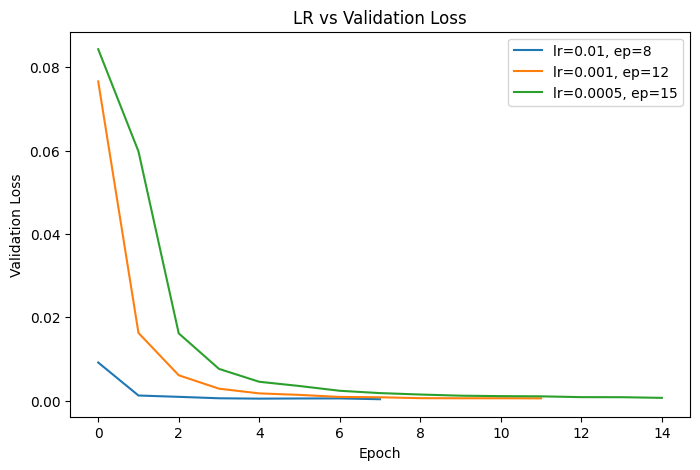

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for (lr, ep), data in results.items():
    plt.plot(data["val"], label=f"lr={lr}, ep={ep}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("LR vs Validation Loss")
plt.legend()
plt.show()


In [28]:
best_key = None
best_loss = float("inf")

for key, data in results.items():
    final_val = data["val"][-1]
    if final_val < best_loss:
        best_loss = final_val
        best_key = key

print("Best config:", best_key)
best_model = results[best_key]["model"]


Best config: (0.01, 8)


In [29]:
torch.save(best_model.state_dict(), "best_pixel_model.pt")
print("Model weights saved.")


Model weights saved.


In [30]:
checkpoint = {
    "model_state": best_model.state_dict(),
    "config": {
        "lr": best_key[0],
        "epochs": best_key[1]
    }
}

torch.save(checkpoint, "best_checkpoint.pt")
print("Checkpoint saved.")


Checkpoint saved.


In [31]:
model = Model().to(DEVICE)

ckpt = torch.load("best_checkpoint.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])

model.eval()
print("Loaded model with config:", ckpt["config"])


Loaded model with config: {'lr': 0.01, 'epochs': 8}


In [32]:
def denorm(v: float) -> int:
    return int(round(float(v * 49)))


In [33]:
import matplotlib.pyplot as plt


def show_predictions(model, dataset, n: int = 5):
    model.eval()

    for i in range(n):
        img, label = dataset[i]

        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(DEVICE))[0].cpu()

        gt = (denorm(label[0]), denorm(label[1]))
        pd = (denorm(pred[0]), denorm(pred[1]))

        plt.imshow(img.squeeze(), cmap="gray")
        plt.scatter(gt[1], gt[0], marker="o", label="GT")
        plt.scatter(pd[1], pd[0], marker="x", label="Pred")
        plt.title(f"GT={gt} Pred={pd}")
        plt.legend()
        plt.show()


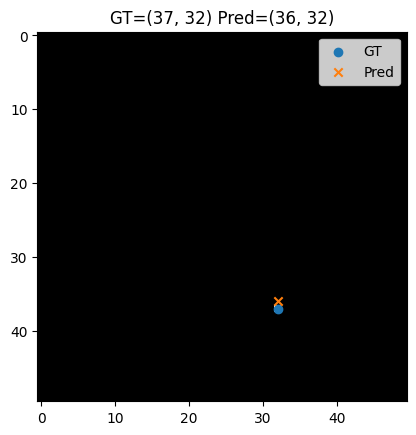

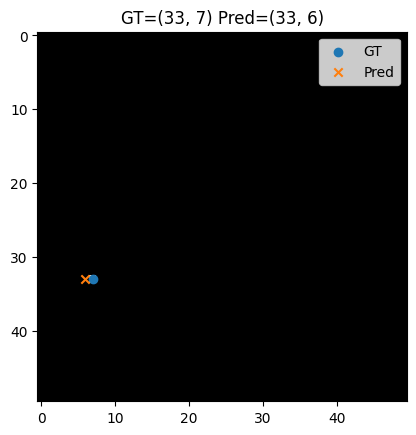

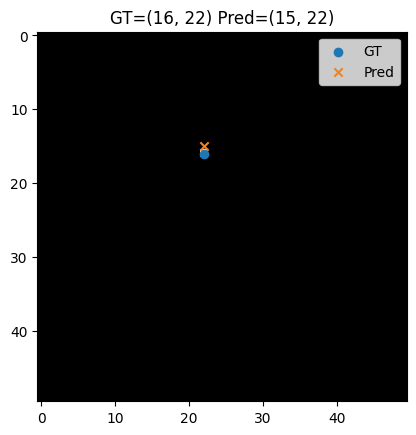

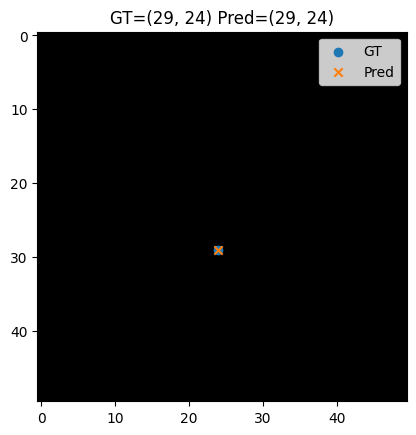

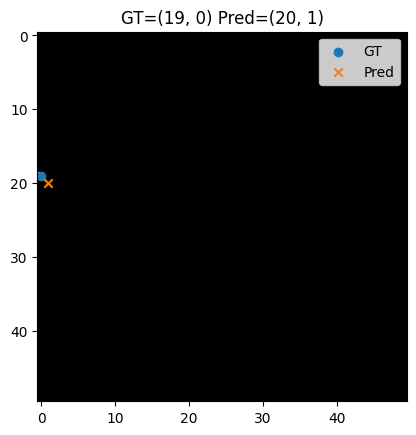

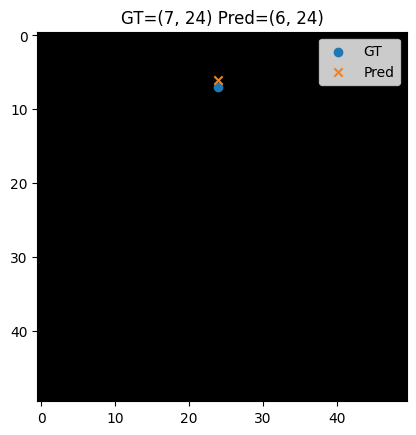

In [34]:
show_predictions(best_model, val_ds, n=6)


## Evaluation Metrics

In [35]:
import math


def pixel_distance(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)


def get_pixel_coords(model, img, label):
    model.eval()

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(DEVICE))[0].cpu()

    gt = (denorm(label[0]), denorm(label[1]))
    pd = (denorm(pred[0]), denorm(pred[1]))

    return gt, pd


In [36]:
def evaluate_metrics(model, dataset):
    errors = []
    
    exact_matches = 0
    x_err = []
    y_err = []

    for img, label in dataset:
        gt, pd = get_pixel_coords(model, img, label)

        errors.append(pixel_distance(gt, pd))

        if gt == pd:
            exact_matches += 1

        x_err.append(abs(gt[0] - pd[0]))
        y_err.append(abs(gt[1] - pd[1]))

    metrics = {
        "mean_pixel_error": sum(errors) / len(errors),
        "exact_match_acc": exact_matches / len(dataset),
        "mean_x_error": sum(x_err) / len(x_err),
        "mean_y_error": sum(y_err) / len(y_err),
    }

    return metrics, errors


In [37]:
metrics, error_list = evaluate_metrics(best_model, val_ds)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


mean_pixel_error: 1.0489
exact_match_acc: 0.2160
mean_x_error: 0.5600
mean_y_error: 0.7000


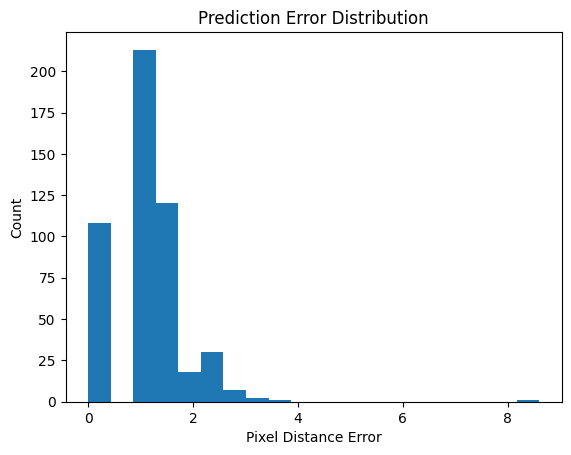

In [38]:
import matplotlib.pyplot as plt

plt.hist(error_list, bins=20)
plt.xlabel("Pixel Distance Error")
plt.ylabel("Count")
plt.title("Prediction Error Distribution")
plt.show()


In [39]:
def within_radius(errors, r):
    return sum(e <= r for e in errors) / len(errors)


print("Within 1px:", within_radius(error_list, 1))
print("Within 2px:", within_radius(error_list, 2))
print("Within 3px:", within_radius(error_list, 3))


Within 1px: 0.642
Within 2px: 0.918
Within 3px: 0.992
